In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import re
import warnings
warnings.filterwarnings('ignore')

import networkx as nx
from networkx.algorithms import bipartite


def minMaxScale(data, imposed_minimum = None, imposed_maximum = None, fit = False): #min max scaling
    mini = min(data)
    maxi = max(data)
    
    if (imposed_minimum != None): mini = imposed_minimum
    if (imposed_maximum != None): maxi = imposed_maximum
    if (fit == False):
        return (data - mini)/(maxi - mini)
    else: 
        return [mini, maxi]

In [2]:
df = pd.read_csv('../data/movies_us.csv')

bal=pd.read_csv('../data/balanced_df.csv').iloc[:, 3:]

act=pd.read_csv('../data/actors_us.csv', index_col = 0)

Building a Bipartite graph between actors and movies, and projecting it onto the actors give us the ability to view and have a better understanding of actor social networks.

In [3]:
# Following cell creates a Bipartite graph of actors and movies which is then projected into actors


# Firstly seperate the movies corresponding to actors from the balanced dataset
ds = df[df['actor'].isin(bal['actor'].tolist())].iloc[:, 2:][['actor', 'title']]
ds.rename({'title':'movie'},inplace=True,axis=1)

# Create the Bipartite graph using NetworkX
B = nx.Graph()
B.add_nodes_from(ds['actor'].drop_duplicates(), bipartite = 0)
B.add_nodes_from(ds['movie'].drop_duplicates(), bipartite = 1)
ds['edges'] = ds.apply(lambda x: (x['actor'], x['movie']), axis = 1)
B.add_edges_from(ds['edges'].values.tolist())

# Project Bipartite graph onto actors

top_nodes = {n for n, d in B.nodes(data=True) if d["bipartite"] == 0}
bottom_nodes = set(B) - top_nodes
G = bipartite.projected_graph(B, top_nodes, multigraph=True)


# find a pair for the actors in the balanced data set according to their connections in the folded network


top_actors = bal['actor'].loc[bal['treatment']==1].tolist()

new_actors = []
pair=[]
duo_appear=[]
for i in top_actors:
    edge_list = G.edges(i)
    alt=pd.DataFrame(edge_list, columns=['actor','pairs'])
    alt=(pd.DataFrame(alt['pairs'].value_counts()))
    alt.rename({'pairs':'weight'},inplace=True,axis=1)
    
    alt.reset_index(inplace=True)
    alt.rename({'index':'pairs'},axis=1,inplace=True)
    
    
    if (not(alt.empty)):
        new_actors.append(i)
        pair.append(alt.sort_values('weight',ascending=False)['pairs'][0])
        duo_appear.append(alt.sort_values('weight',ascending=False)['weight'][0])


top_ap=act[act['actor'].isin(top_actors)].sort_values(
    by = 'grade_sum', ascending = False)[['actor','appearances','grade_sum','grade_avg']]
top_ap.rename({'actor':'top','appearances':'appearances_top','grade_sum':'grade_sum_top','grade_avg':'grade_avg_top'},
              inplace=True,axis=1)
pair_ap=act[act['actor'].isin(pair)].sort_values(
    by = 'grade_sum', ascending = False)[['actor','appearances','grade_sum','grade_avg']]
pair_ap.rename({'actor':'pair','appearances':'appearances_pair','grade_sum':'grade_sum_pair','grade_avg':'grade_avg_pair'},
              inplace=True,axis=1)

duos=pd.DataFrame({'top':new_actors,'pair':pair,'duo_appear':duo_appear})

duos=duos[duos['duo_appear']>1]

duos=duos.merge(top_ap,on='top').merge(pair_ap,on='pair')

duos['top_solo']=(duos['appearances_top']-duos['duo_appear']).abs()
duos['pair_solo']=(duos['appearances_pair']-duos['duo_appear']).abs()
duos['grade_avg_diff']=(duos['grade_avg_top']-duos['grade_avg_pair']).abs()
duos['appearances_diff']=(duos['appearances_top']-duos['appearances_pair']).abs()
duos.sort_values('duo_appear', inplace=True,ascending=False)
duos.head(3)


,top,pair,duo_appear,appearances_top,grade_sum_top,grade_avg_top,appearances_pair,grade_sum_pair,grade_avg_pair,top_solo,pair_solo,grade_avg_diff,appearances_diff
427,Gene_Autry,Smiley_Burnette,48,108,212.890570,1.971209,106,191.616891,1.807707,60,58,0.163502,2
496,Smiley_Burnette,Gene_Autry,48,106,191.616891,1.807707,108,212.890570,1.971209,58,60,0.163502,2
202,Chieko_Baishô,Kiyoshi_Atsumi,43,74,168.282071,2.274082,56,116.629354,2.082667,31,13,0.191415,18


In [18]:
duos.sort_values('grade_avg_diff',ascending=False,inplace=True)
duos['ratiot']=duos['duo_appear']/duos['appearances_top']
duos['ratiop']=duos['duo_appear']/duos['appearances_pair']
test_pairs=duos.sort_values('duo_appear',ascending=False)
test_pairs.head(3)

,top,pair,duo_appear,appearances_top,grade_sum_top,grade_avg_top,appearances_pair,grade_sum_pair,grade_avg_pair,top_solo,pair_solo,grade_avg_diff,appearances_diff,ratiot,ratiop
496,Smiley_Burnette,Gene_Autry,48,106,191.616891,1.807707,108,212.890570,1.971209,58,60,0.163502,2,0.452830,0.444444
427,Gene_Autry,Smiley_Burnette,48,108,212.890570,1.971209,106,191.616891,1.807707,60,58,0.163502,2,0.444444,0.452830
185,Kiyoshi_Atsumi,Chieko_Baishô,43,56,116.629354,2.082667,74,168.282071,2.274082,13,31,0.191415,18,0.767857,0.581081


In [5]:
pair_tuples=test_pairs.apply(lambda x:(x['top'],x['pair']),axis=1)
pairs = list({*map(tuple, map(sorted, pair_tuples))})#remove duplicates -> tuple magic
len(pairs)

4069

Once the pairs have been identified, the assesment of the individual careers of each member (alone without the other) of the pair becomes necessary to understad who relies on who. 

In [6]:
import math

# Eliminating columns with redundant values that could interfer with duplicate removal
f=df.copy().iloc[:,3:]
f.drop(['attributes','types','isOriginalTitle','ordering'],axis=1,inplace=True)
f.drop_duplicates(inplace=True)

a=[] # Average grade rating of actor a's solo career
b=[] # Average grade rating of actor b's solo career
c=[] # Average grade rating of actors a and b common career
d=[] # Appearances of each actor
e=[] # Appearances together
test_m=[] 
test_p=[]
p=[] # Pairs left after eliminating pairs who strictly acted together

for i in pairs:
    mov=f[['actor','title','averageRating_adj']].loc[(f['actor']==i[0]) | (f['actor']==i[1])] # Movies of a and b
    
    # Identifying movies in which a nd b stared togther
    mov['common']=mov['title'].duplicated(keep='last') 
    common_mv=mov[mov['common']==True]
    sep_mv=mov.drop_duplicates(['title']).loc[mov['common']==False]
    

    # Solo movie average ratings of a and b
    a_avg=sep_mv['averageRating_adj'].loc[(mov['actor']==i[0])]
    b_avg=sep_mv['averageRating_adj'].loc[(mov['actor']==i[1])]
    if math.isnan(a_avg.mean()) | math.isnan(b_avg.mean()): # Eliminating actors who only acted together from the set
        continue
        
    # Appending average values for all movies in corresponding sets of the adjusted average rating
    a.append(a_avg.mean())
    b.append(b_avg.mean())
    c.append(mov['averageRating_adj'].loc[(mov['common']==True)].mean())
    d.append((bal['appearances'].loc[bal['actor']==i[0]].values,bal['appearances'].loc[bal['actor']==i[1]].values))
    e.append(duos['appearances_pair'].loc[(duos['top']==i[0]) & (duos['pair']==i[1])])
    
    # Conducting Mann Whitney Statistical Test between actor solo careers
    test_m.append(stats.mannwhitneyu(a_avg,b_avg)[0])
    test_p.append(stats.mannwhitneyu(a_avg,b_avg)[1])
    
    p.append((i[0],i[1]))
    
    
x=pd.DataFrame({'Pairs':p,'Avg_a':a,'Avg_b':b,'Avg_common':c,'app':d,'app_c':e,'test_m':test_m,'test_p':test_p})

In [7]:
x['solo_diff']=x['Avg_a']-x['Avg_b'] # Difference between grade average rating of solo movies of a and b
x['cdiff_a']=x['Avg_a']-x['Avg_common'] # Difference between grade average rating of solo movies of a and common movies
x['cdiff_b']=x['Avg_b']-x['Avg_common'] # Difference between grade average rating of solo movies of b and common movies
x.sort_values('solo_diff',inplace=True)
x['solo_diff']=x['solo_diff'].abs()

In [8]:
# Labeling less successful actors in each pair

def g(a,b,c):
    if a<b:
        return c[0]
    else:
        return c[1]

x['pig']=x.apply(lambda a: g(a['Avg_a'],a['Avg_b'],a['Pairs']),axis=1)

In [9]:
# Percentage of alleged piggy backers in treatment group using bonferroni correction
alpha=0.05/len(x)
len(x.query(f'test_p<{alpha}'))*0.5/len(x)

0.011657056906492855

1.16% of the treaatment group consisted of piggy backers according to this analysis. This makes sense given that this group consists of what are considered successful actors, hence why having a small percentage of piggy backers among themselves makes sense. A Bonferroni correction is used give that the statistical tests were carried out for all the pairs (4069)

In [16]:
#Mann-whitney u test between piggybackers and rest of treatment set

new=pd.merge(bal,x,left_on='actor',right_on='pig')
print(stats.mannwhitneyu(bal['grade_avg'].loc[bal['actor']!=new['actor'].values.any()].dropna(),new['grade_avg']))

MannwhitneyuResult(statistic=44391724.0, pvalue=2.9204292165690465e-14)


According to the Mann-Whitney U test conducted, one can reject the null hypothesis due to the extremely tiny p-value, which indicates that the two group indeed belong to different distributions

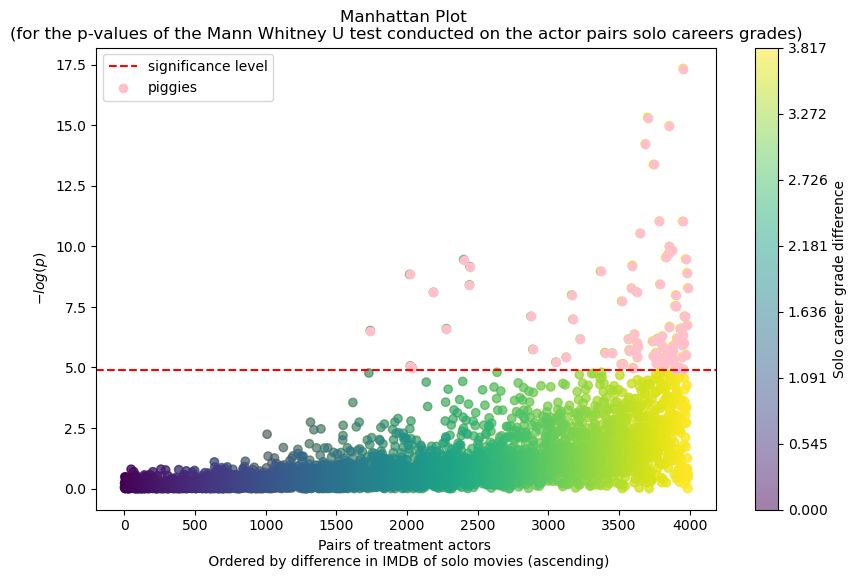

In [17]:
# Plotting Manhattan Chart for the p-values of the Mann Whitney U test conducted on the actors solo careers
plt.figure(figsize = (10, 6))
x = x.sort_values('solo_diff', ascending = True).reset_index(drop = True)
#x = x.sample(frac = 1).reset_index(drop = True)
x['logp'] = -np.log10(x['test_p'])
#Bonferroni correction on the statistical significance
sig_level = -np.log10(0.05/len(x))

clist = [item/255 for item in x.index.tolist()]
plt.scatter(x = x.index, y = x.logp, c = clist, alpha = 0.5)

plt.title('Manhattan Plot \n'
'(for the p-values of the Mann Whitney U test conducted on the actor pairs solo careers grades)')

plt.axhline(sig_level, color = 'r', linestyle = '--', label = 'significance level')
plt.ylabel("$-log(p)$")
plt.xlabel('Pairs of treatment actors \n Ordered by difference in IMDB of solo movies (ascending)')

plt.clim(x['solo_diff'].min(), x['solo_diff'].max())
ticks = np.linspace(x['solo_diff'].min(), x['solo_diff'].max(), 8, endpoint=True)
plt.colorbar(label = "Solo career grade difference", orientation = "vertical", ticks = ticks)
plt.scatter(x = x.index, y = x.logp, c = clist, alpha = 0.6)

#coloring piggies a different color
piggies = x[x['logp'] > sig_level]
plt.scatter(x = piggies.index, y = piggies.logp, c = 'pink',marker = 'o', label = 'piggies')

plt.legend()
plt.savefig('manhattanplt.png', bbox = 'tight')
plt.show()

In a Manhattan plot, traditionally used for genome analysis with the purpose of displaying the significant single-nucleotide polymorphisms, the negative logarithm of the p-values of the individual points are displayed with the aim of having a visualization of how much of the results lie below the significance level defined with the Bonferroni correction